### 1. Importing core libraries

In [4]:
import csv
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import helpers as hlp

### 2. Loading dataset from csv files
This will load csv files containing training metadata into memory.
In order to load datasets pass a list of directories with samples.

In [5]:
# datasets = ['track_1_straight', 'track_1_reverse',
#             'track_2_straight', 'track_2_reverse']

# datasets = ['track_1_straight', 'track_1_reverse']

datasets = ['udacity_samples']

samples = []

for dataset in datasets:
    with open(f'./data/{dataset}/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)

### 3a. Loading the data into memory
If the sample is not too big, execute cells below and load samples into memory. Otheriwse choose cells in 3b to pass samples as a generator.

Cell below loads sets of images from left, center and right cameras incl a steering angle at current time frame. Steering angle for left and right cameras is adjusted by applying correction.
Before moving on to the next step, images are preprocessed with the help of a function hlp.preprocess() which takes raw image as an input, crops the irrelevent sections of the image (hood of the car and landscape), applies gaussian blur, to reduce noise, resizes the image to 200x66 as suggested in [Nvidia's paper](https://devblogs.nvidia.com/deep-learning-self-driving-cars/), and finally converts the RGB colorspace to YUV, also as suggested in Nvidia's post. You can find hlp.preprocess() function inside helpers.py within main directory.

The final step of loading the images is augmenting the samples by flipping them horizontally.

In [34]:
images = []
steering_angles = []
for line in samples:
    steering_center = float(line[3])
    
    correction = 0.2
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    path_center = 'data/udacity_samples/' + line[0].replace(" ","")
    path_left = 'data/udacity_samples/' + line[1].replace(" ","")
    path_right = 'data/udacity_samples/' + line[2].replace(" ","")
    img_center = hlp.preprocess(plt.imread(os.path.abspath(path_center)))
    img_left = hlp.preprocess(plt.imread(os.path.abspath(path_left)))
    img_right = hlp.preprocess(plt.imread(os.path.abspath(path_right)))
    
    images.extend([img_center, img_left, img_right])
    steering_angles.extend([steering_center, steering_left, steering_right])
    
augmented_images = []
augmented_steering_angles = []
for image, steering_angle in zip(images, steering_angles):
    augmented_images.append(image)
    augmented_steering_angles.append(steering_angle)
    augmented_images.append(cv2.flip(image,1))
    augmented_steering_angles.append(steering_angle*-1.0)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_steering_angles)

Below is the sample of preprocessed image.

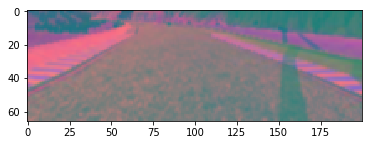

In [27]:
plt.imshow(X_train[0])

### 3b. Spliting the data and passing a generator
If your dataset won't fit into memory, choose this approach.

Firstly the datasets are split into training and validation samples, then train generators and validation generators are created. Train generators consist of the same preprocessing steps as the one previously explained.

In [3]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [4]:
from sklearn.utils import shuffle

def generator(samples, batch_size=64):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            steering_angles = []
            for batch_sample in batch_samples:
                
                steering_center = float(line[3])
                
                correction = 0.2
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                img_center = plt.imread(line[0])
                img_left = plt.imread(line[1])
                img_right = plt.imread(line[2])
                
                images.extend([img_center, img_left, img_right])
                steering_angles.extend([steering_center, steering_left, steering_right])
            
            augmented_images = []
            augmented_steering_angles = []
            for image, steering_angle in zip(images, steering_angles):
                augmented_images.append(image)
                augmented_steering_angles.append(steering_angle)
                augmented_images.append(cv2.flip(image,1))
                augmented_steering_angles.append(steering_angle*-1.0)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_steering_angles)
            yield shuffle(X_train, y_train)

In [5]:
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

### 4. Creating model architecture
Model is a CNN architecture based on Nvidia's paper.

In [35]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [36]:
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66,200,3)))
model.add(Conv2D(24,(5,5), activation="relu", strides=(2,2)))
model.add(Conv2D(36,(5,5), activation="relu", strides=(2,2)))
model.add(Conv2D(48,(5,5), activation="relu", strides=(2,2)))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(Conv2D(64,(3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

### 5a. Feeding training data from memory

In [37]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=3)

Train on 38572 samples, validate on 9644 samples
Epoch 1/3
38572/38572 [==============================] - 26s 677us/step - loss: 0.0165 - val_loss: 0.0187
Epoch 2/3
38572/38572 [==============================] - 21s 550us/step - loss: 0.0131 - val_loss: 0.0186
Epoch 3/3
38572/38572 [==============================] - 21s 551us/step - loss: 0.0118 - val_loss: 0.0210


### 5b. Passing training and validation generators

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples),
                    epochs=3,
                    verbose=1)

### 6. Saving the model

In [38]:
model.save('model_6.h5')